In [35]:
import kagglehub
from pathlib import Path
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import shutil, os
import matplotlib.pyplot as plt
import itertools

In [ ]:
# Creando el API token de kaggle y subir el dataset desde allí:
from google.colab import files

uploaded = files.upload()
print("✅ Archivo(s) subido(s):", list(uploaded.keys()))

In [19]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:34<00:01, 19.8MB/s]
100% 2.29G/2.29G [00:34<00:00, 71.0MB/s]


In [20]:
!unzip chest-xray-pneumonia.zip -d chest_xray_dataset

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_dataset/chest_xray/train/NORMAL/IM-0442-0001.jpe

In [22]:
!ls chest_xray_dataset/chest_xray/train
!ls chest_xray_dataset/chest_xray/test

NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [23]:
!mkdir -p chest_xray_ready/train/NORMAL
!mkdir -p chest_xray_ready/train/BACTERIAL
!mkdir -p chest_xray_ready/train/VIRAL

!mkdir -p chest_xray_ready/test/NORMAL
!mkdir -p chest_xray_ready/test/BACTERIAL
!mkdir -p chest_xray_ready/test/VIRAL

In [24]:
for img in os.listdir("chest_xray_dataset/chest_xray/train/NORMAL"):
    shutil.move(
        f"chest_xray_dataset/chest_xray/train/NORMAL/{img}",
        "chest_xray_ready/train/NORMAL/"
    )

for img in os.listdir("chest_xray_dataset/chest_xray/test/NORMAL"):
    shutil.move(
        f"chest_xray_dataset/chest_xray/test/NORMAL/{img}",
        "chest_xray_ready/test/NORMAL/"
    )

print("✅ Normales movidos!")

✅ Normales movidos!


In [25]:
for img in os.listdir("chest_xray_dataset/chest_xray/train/PNEUMONIA"):
    if "bacteria" in img.lower():
        shutil.move(
            f"chest_xray_dataset/chest_xray/train/PNEUMONIA/{img}",
            "chest_xray_ready/train/BACTERIAL/"
        )
    elif "virus" in img.lower():
        shutil.move(
            f"chest_xray_dataset/chest_xray/train/PNEUMONIA/{img}",
            "chest_xray_ready/train/VIRAL/"
        )

for img in os.listdir("chest_xray_dataset/chest_xray/test/PNEUMONIA"):
    if "bacteria" in img.lower():
        shutil.move(
            f"chest_xray_dataset/chest_xray/test/PNEUMONIA/{img}",
            "chest_xray_ready/test/BACTERIAL/"
        )
    elif "virus" in img.lower():
        shutil.move(
            f"chest_xray_dataset/chest_xray/test/PNEUMONIA/{img}",
            "chest_xray_ready/test/VIRAL/"
        )

print("✅ Neumonías separadas!")

✅ Neumonías separadas!


In [26]:
!ls chest_xray_ready/train/NORMAL | wc -l
!ls chest_xray_ready/train/BACTERIAL | wc -l
!ls chest_xray_ready/train/VIRAL | wc -l

!ls chest_xray_ready/test/NORMAL | wc -l
!ls chest_xray_ready/test/BACTERIAL | wc -l
!ls chest_xray_ready/test/VIRAL | wc -l

1341
2530
1345
234
242
148


In [28]:
train_dir = "chest_xray_ready/train"
test_dir  = "chest_xray_ready/test"

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test  = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode="categorical"
)

test_gen = datagen_test.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)

train_gen.class_indices

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


{'BACTERIAL': 0, 'NORMAL': 1, 'VIRAL': 2}

In [29]:
train_dir = "chest_xray_ready/train"
test_dir  = "chest_xray_ready/test"

# Generadores de imágenes
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test  = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen_test.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [ ]:
# Modelo rápido con transfer learning
backbone = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
backbone.trainable = False

model = models.Sequential([
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,075 (8.77 MB)

 Trainable params: 41,091 (160.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [30]:
#Rutas
train_dir = "chest_xray_ready/train"
test_dir  = "chest_xray_ready/test"

#Generadores
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test  = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen_test.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [39]:
# Modelo liviano de prueba
backbone = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
backbone.trainable = False

model = models.Sequential([
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Entrenamiento rápido
history = model.fit(train_gen, epochs=6)

# 5. Métricas de 3 clases
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
labels = list(train_gen.class_indices.keys())

print("\n=== Métricas por clase ===\n")
print(classification_report(y_true, y_pred, target_names=labels))

print("\n=== Matriz de confusión ===\n")
print(confusion_matrix(y_true, y_pred))

# 6. Guardar modelo
model.save("modelo_neumonia_triclase_fast.h5")

print("\n✅ Modelo guardado como modelo_neumonia_triclase_fast.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.6504 - loss: 0.7708
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7835 - loss: 0.5191
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7990 - loss: 0.4753
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8085 - loss: 0.4445
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8238 - loss: 0.4300
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8259 - loss: 0.4012
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step



=== Métricas por clase ===

              precision    recall  f1-score   support

   BACTERIAL       0.76      0.98      0.86       242
      NORMAL       0.96      0.73      0.83       234
       VIRAL       0.72      0.66      0.69       148

    accuracy                           0.81       624
   macro avg       0.81      0.79      0.79       624
weighted avg       0.82      0.81      0.80       624


=== Matriz de confusión ===

[[237   4   1]
 [ 27 170  37]
 [ 47   4  97]]

✅ Modelo guardado como modelo_neumonia_triclase_fast.h5


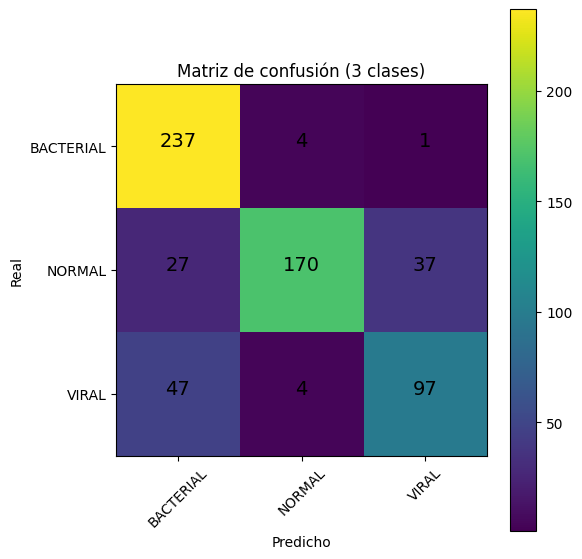

In [41]:
# Graficando la matrix de confusión:
cm = confusion_matrix(test_gen.classes, y_pred)
class_names = ["BACTERIAL", "NORMAL", "VIRAL"]

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión (3 clases)")
plt.colorbar()

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             fontsize=14)

plt.xticks(range(3), class_names, rotation=45)
plt.yticks(range(3), class_names)
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.show()

In [42]:
y_classes = train_gen.classes
unique_classes = np.unique(y_classes)

weights = compute_class_weight('balanced', classes=unique_classes, y=y_classes)
class_weights = {i: w for i, w in enumerate(weights)}

print("✅ Class weights calculados:", class_weights)

✅ Class weights calculados: {0: np.float64(0.6872200263504611), 1: np.float64(1.2965448670146658), 2: np.float64(1.2926889714993803)}


In [43]:
backbone = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
backbone.trainable = False  # rápido y estable como transfer learning

model = models.Sequential([
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,171 (9.27 MB)

 Trainable params: 172,803 (675.01 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

None


In [44]:
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=2, verbose=1),
    callbacks.ModelCheckpoint("modelo_robusto.keras", monitor="val_loss", save_best_only=True, verbose=1),
]
print("✅ Callbacks configurados\n")

✅ Callbacks configurados



In [45]:
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.1)

val_gen = datagen_val.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("✅ val_gen creado correctamente")

Found 521 images belonging to 3 classes.
✅ val_gen creado correctamente


In [46]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6321 - loss: 0.8951

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.39679, saving model to modelo_robusto.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.6324 - loss: 0.8943 - val_accuracy: 0.8560 - val_loss: 0.3968 - learning_rate: 5.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7441 - loss: 0.5670
Epoch 2: val_loss improved from 0.39679 to 0.32966, saving model to modelo_robusto.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7441 - loss: 0.5671 - val_accuracy: 0.8983 - val_loss: 0.3297 - learning_rate: 5.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7809 - loss: 0.4933
Epoch 3: val_loss improved from 0.32966 to 0.27707, saving model to modelo_robusto.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.7808 - loss: 0.4934 - val_accuracy: 0.9040 - val_loss: 0.2771 - learning_rate: 5.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7967 - loss: 0.4643
Epoch 4: val_loss improved from 0.27707 to 

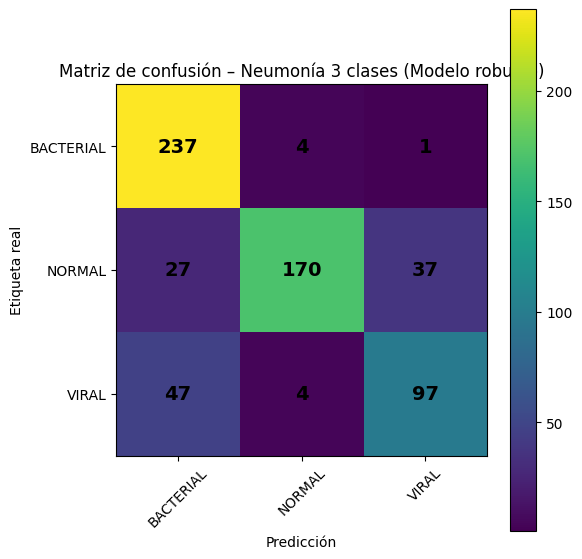

In [47]:
cm = confusion_matrix(y_true, y_pred)

labels = list(train_gen.class_indices.keys())  # ['NORMAL', 'BACTERIAL', 'VIRAL']

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión – Neumonía 3 clases (Modelo robusto)")
plt.colorbar()

# Colocar números dentro de cada celda
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha='center',
             va='center',
             fontsize=14,
             fontweight='bold')

plt.xticks(range(3), labels, rotation=45)
plt.yticks(range(3), labels)
plt.ylabel('Etiqueta real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

In [48]:
# === MODELO 3: MobileNetV2 con fine-tuning parcial ===

# Backbone con pesos ImageNet
backbone_ft = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

backbone_ft.trainable = True

# Se congelan la mayoría d capas y se dejans entrenables solo las últimas ~40
for layer in backbone_ft.layers[:-40]:
    layer.trainable = False

print("Capas totales:", len(backbone_ft.layers))
print("Capas entrenables:", np.sum([l.trainable for l in backbone_ft.layers]))

Capas totales: 154
Capas entrenables: 40


In [49]:
# Cabeza densa robusta (similar al modelo anterior, para comparar coherentemente)
model3 = models.Sequential([
    backbone_ft,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(3, activation="softmax")
])

# Compilación: LR bajito porque estamos ajustando parte del backbone
from tensorflow.keras import optimizers
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print(model3.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,171 (9.27 MB)

 Trainable params: 1,854,339 (7.07 MB)

 Non-trainable params: 576,832 (2.20 MB)

None


In [50]:
# Callbacks: mismos criterios de robustez
cbs3 = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        "modelo_finetune_definitivo.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [51]:
# Entrenamiento del modelo 3
history3 = model3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    class_weight=class_weights,
    callbacks=cbs3,
    verbose=1
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4444 - loss: 1.3788
Epoch 1: val_loss improved from inf to 1.10568, saving model to modelo_finetune_definitivo.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.4448 - loss: 1.3777 - val_accuracy: 0.4990 - val_loss: 1.1057 - learning_rate: 1.0000e-05
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6069 - loss: 0.9119
Epoch 2: val_loss did not improve from 1.10568
163/163 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.6071 - loss: 0.9117 - val_accuracy: 0.5336 - val_loss: 1.1279 - learning_rate: 1.0000e-05
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6752 - loss: 0.7665
Epoch 3: val_loss improved from 1.10568 to 0.98535, saving model to modelo_finetune_definitivo.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6752 - loss: 0.7665 - val_accuracy: 0.5893 - val_loss: 0.9854 - learning_rate: 1.0000e-05
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7

In [52]:
# Evaluación en test
y_true = test_gen.classes
y_pred3 = np.argmax(model3.predict(test_gen), axis=1)
labels = list(train_gen.class_indices.keys())

print("\n=== RESULTADOS MODELO 3 (FINETUNE PARCIAL) ===\n")
print("Índices de clase:", train_gen.class_indices)

from sklearn.metrics import classification_report, confusion_matrix
print("\n--- Classification report ---\n")
print(classification_report(y_true, y_pred3, target_names=labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step

=== RESULTADOS MODELO 3 (FINETUNE PARCIAL) ===

Índices de clase: {'BACTERIAL': 0, 'NORMAL': 1, 'VIRAL': 2}

--- Classification report ---

              precision    recall  f1-score   support

   BACTERIAL       0.69      0.84      0.76       242
      NORMAL       0.94      0.44      0.60       234
       VIRAL       0.42      0.63      0.50       148

    accuracy                           0.64       624
   macro avg       0.69      0.64      0.62       624
weighted avg       0.72      0.64      0.64       624



In [ ]:
# Matriz de confusión
cm3 = confusion_matrix(y_true, y_pred3)
print("\n--- Confusion matrix ---\n")
print(cm3)

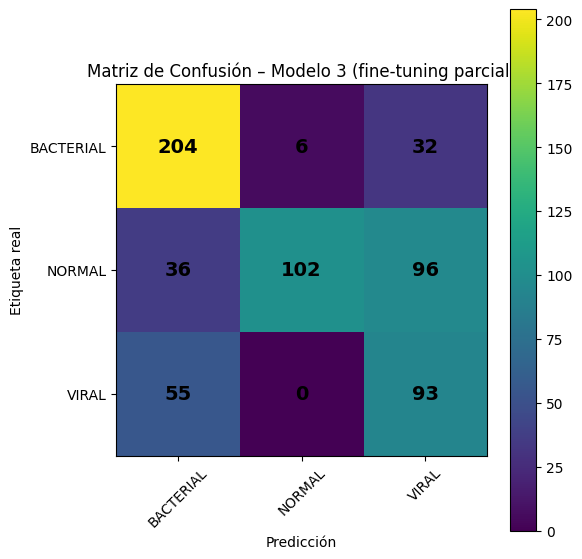

In [54]:
# Matriz de confusión pintada
plt.figure(figsize=(6,6))
plt.imshow(cm3, interpolation='nearest')
plt.title("Matriz de Confusión – Modelo 3 (fine-tuning parcial)")
plt.colorbar()

for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
    plt.text(j, i, cm3[i, j],
             ha='center', va='center',
             fontsize=14, fontweight='bold')

plt.xticks(range(3), labels, rotation=45)
plt.yticks(range(3), labels)
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()